# Model evaluation using Sidekick
In this notebook you will learn how to use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. To install the package within the notebook, run the following code:

`
import sys
!{sys.executable} -m pip install git+https://github.com/Peltarion/sidekick#egg=sidekick
`

For more information about Sidekick, see:
https://github.com/Peltarion/sidekick

In [3]:
import os
import operator
import itertools
import resource
import zipfile

from IPython.display import display, Image
import pandas as pd
from PIL import Image
import sidekick

## Setup

### Path to preprocessed dataset

In [15]:
zip_path = './preprocessed.zip'
dataset_path = str.split(os.path.basename(dataset_path),'.zip')[0]
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(dataset_path)
zip_ref.close()

### Platform deployment

In [3]:
deploy_url = 'https:...'
deploy_token = '...'

### Helper functions

In [4]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)

def get_image(path):
    im = Image.open(os.path.join(dataset_path, path))
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

## Getting single  predictions

### Deployment

In [5]:
client = sidekick.Deployment(
    # Enter URL and token
    url=deploy_url,
    token=deploy_token,
    dtypes_in={'image': 'Image (224x224x3)'},
    dtypes_out={'class': 'Categorical (8)'}
)

### Ground truth

In [6]:
df = pd.read_csv(os.path.join(dataset_path, 'index.csv'))
df = df.sample(frac=1, random_state=2323)
df.head()

,image,class,subset
2926,image/754.jpeg,glass_shatter,T
993,image/993.jpeg,head_lamp,T
671,image/671.jpeg,unknown,T
3414,image/787.jpeg,head_lamp,T
1260,image/1260.jpeg,head_lamp,V


### Predict damage for one image

In [7]:
im_path_list = iter(list(df['image']))

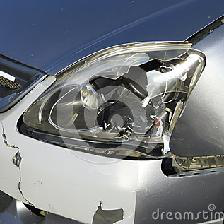

('head_lamp', 0.9945121)


In [9]:
im_path = next(im_path_list)
im = Image.open(os.path.join(dataset_path, im_path))
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

### Predict damage for multiple images

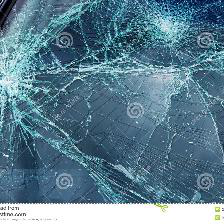

Ground truth: glass_shatter
Prediction: {'bumper_scratch': 0.00043586732, 'head_lamp': 7.3072224e-05, 'door_scratch': 0.0014962385, 'glass_shatter': 0.9970431, 'bumper_dent': 6.020762e-05, 'door_dent': 0.0006840901, 'tail_lamp': 2.8641702e-05, 'unknown': 0.00017860174}


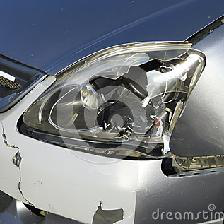

Ground truth: head_lamp
Prediction: {'bumper_scratch': 0.00036793892, 'head_lamp': 0.9945121, 'door_scratch': 2.4985652e-06, 'glass_shatter': 4.5231543e-05, 'bumper_dent': 3.2129105e-05, 'door_dent': 4.5534443e-06, 'tail_lamp': 0.0035361303, 'unknown': 0.0014993472}


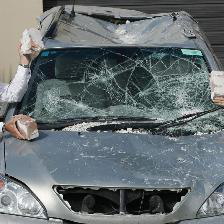

Ground truth: unknown
Prediction: {'bumper_scratch': 0.00015750024, 'head_lamp': 0.045774635, 'door_scratch': 0.00045894476, 'glass_shatter': 0.31350154, 'bumper_dent': 0.00059478614, 'door_dent': 0.010806459, 'tail_lamp': 0.00096945354, 'unknown': 0.62773675}


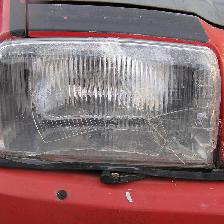

Ground truth: head_lamp
Prediction: {'bumper_scratch': 0.0021527794, 'head_lamp': 0.7120998, 'door_scratch': 0.00031435437, 'glass_shatter': 0.030974489, 'bumper_dent': 0.0013042705, 'door_dent': 0.0007464599, 'tail_lamp': 0.24088944, 'unknown': 0.011518416}


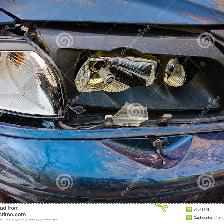

Ground truth: head_lamp
Prediction: {'bumper_scratch': 0.0014532884, 'head_lamp': 0.9489586, 'door_scratch': 3.365826e-06, 'glass_shatter': 0.00053182803, 'bumper_dent': 6.77116e-05, 'door_dent': 1.4388089e-05, 'tail_lamp': 0.029343711, 'unknown': 0.019627046}


In [10]:
first_rows = df.head()
for i, row in first_rows.iterrows():
    img = Image.open(os.path.join(dataset_path, row['image']))
    display(img)
    pred = client.predict(image=img)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], pred['class']))

## Getting predictions (batch)

### Filter out training data
The predictions on the evaluation subset will be used in the analysis of the deployed model.

In [11]:
# Validation data
eval_df = df[df['subset']=='V'].copy()

### Batch request

In [12]:
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))
eval_df.head(1)

,image,class,subset,image_url
1260,<PIL.Image.Image image mode=RGB size=224x224 a...,head_lamp,V,image/1260.jpeg


In [13]:
#This may take several minutes...
preds = [p for p in predictions]
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(5)

,image,class,subset,image_url,pred
1260,<PIL.Image.Image image mode=RGB size=224x224 a...,head_lamp,V,image/1260.jpeg,"{'bumper_scratch': 0.0014532884, 'head_lamp': ..."
1407,<PIL.Image.Image image mode=RGB size=224x224 a...,unknown,V,image/1407.jpeg,"{'bumper_scratch': 6.9384696e-06, 'head_lamp':..."
1385,<PIL.Image.Image image mode=RGB size=224x224 a...,door_scratch,V,image/1385.jpeg,"{'bumper_scratch': 0.0051175468, 'head_lamp': ..."
1452,<PIL.Image.Image image mode=RGB size=224x224 a...,head_lamp,V,image/1452.jpeg,"{'bumper_scratch': 0.0013226427, 'head_lamp': ..."
1262,<PIL.Image.Image image mode=RGB size=224x224 a...,tail_lamp,V,image/1262.jpeg,"{'bumper_scratch': 2.3494192e-06, 'head_lamp':..."


## Evaluation

In [14]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(5)

,image,class,subset,image_url,pred,pred_class,pred_score
1260,<PIL.Image.Image image mode=RGB size=224x224 a...,head_lamp,V,image/1260.jpeg,"{'bumper_scratch': 0.0014532884, 'head_lamp': ...",head_lamp,0.948959
1407,<PIL.Image.Image image mode=RGB size=224x224 a...,unknown,V,image/1407.jpeg,"{'bumper_scratch': 6.9384696e-06, 'head_lamp':...",unknown,0.999104
1385,<PIL.Image.Image image mode=RGB size=224x224 a...,door_scratch,V,image/1385.jpeg,"{'bumper_scratch': 0.0051175468, 'head_lamp': ...",door_dent,0.511280
1452,<PIL.Image.Image image mode=RGB size=224x224 a...,head_lamp,V,image/1452.jpeg,"{'bumper_scratch': 0.0013226427, 'head_lamp': ...",head_lamp,0.802253
1262,<PIL.Image.Image image mode=RGB size=224x224 a...,tail_lamp,V,image/1262.jpeg,"{'bumper_scratch': 2.3494192e-06, 'head_lamp':...",tail_lamp,0.999028


### Worst misclassified examples

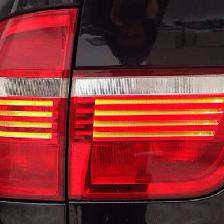

Ground truth: unknown, Prediction: tail_lamp, Score: 0.9875832


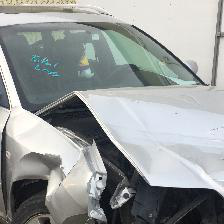

Ground truth: unknown, Prediction: glass_shatter, Score: 0.9838694


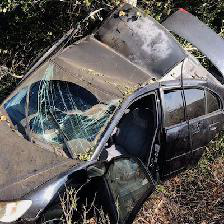

Ground truth: unknown, Prediction: glass_shatter, Score: 0.96513766


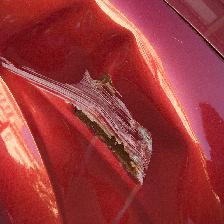

Ground truth: door_dent, Prediction: glass_shatter, Score: 0.9161198


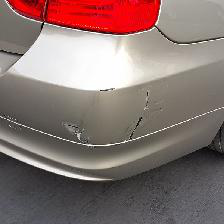

Ground truth: bumper_scratch, Prediction: bumper_dent, Score: 0.90754205


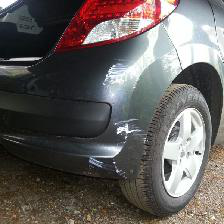

Ground truth: bumper_scratch, Prediction: bumper_dent, Score: 0.889421


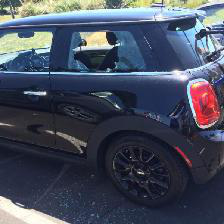

Ground truth: glass_shatter, Prediction: unknown, Score: 0.88899976


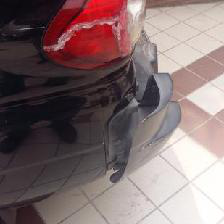

Ground truth: tail_lamp, Prediction: bumper_dent, Score: 0.87981784


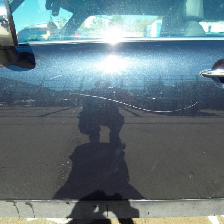

Ground truth: door_scratch, Prediction: bumper_dent, Score: 0.83997345


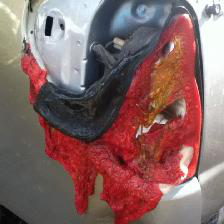

Ground truth: tail_lamp, Prediction: bumper_dent, Score: 0.8346801


In [15]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))